#Start#
Data is imported into the notebook from their corresponding .csv files. The required python modules and packages are imported.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
root = 'gdrive/My Drive/IBM Hack/data/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import pandas as pd
import sklearn
import numpy as np

In [3]:
df1=pd.read_csv(f"{root}train.csv")

In [4]:
df2=pd.read_csv(f"{root}meal_info.csv")

In [5]:
df3=pd.read_csv(f"{root}fulfilment_center_info.csv")


The 3 different dataframes are merged into one to perform further operations and derive inferences. Since the no. of columns of all 3 dataframes are same, they are merged without any shape changes.

In [6]:
df_raw=pd.merge(df1,df2,on='meal_id')
df_raw=df=pd.merge(df_raw,df3,on='center_id')

In [7]:
df_raw.to_csv(f"{root}/df_raw.csv")

The combined dataframe is then viewed to see all the columns and it's shape.

In [ ]:
def to_cat(df,cols):
  mapping={}
  for col in cols:
    mapping[col]={}
    df_cat=pd.DataFrame(df[col].astype('category'))
    unq=df[col].unique()
    for val in unq:
      mapping[col][val]=df_cat.loc[df_cat[col]==val,col].cat.codes.iloc[0]
    df.loc[:,col]=df[col].astype('category').cat.codes
  return mapping

In [ ]:
mapping=to_cat(df,['category','cuisine','center_type'])
df['discount']=(df.base_price-df.checkout_price)/df.base_price

The categories are then label encoded to perform different operations on the data.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['num_orders','id','week'],axis=1), df.num_orders, test_size=0.2,shuffle=False)

The dataset is then split into train and test data with a specific weightage. This helps in improving the accuracy of the model on the real test dataset because we are able to derive inferences about the model from the mock test dataset which helps in twitching the model for better performance.

In [ ]:
from xgboost import XGBRegressor, DMatrix

In [ ]:
model=XGBRegressor(max_depth=10,n_estimators=200, n_jobs=-1,subsample=0.8,eta=0.2)

In [ ]:
model.fit(X_train, y_train)

[16:19:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.2, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

In [ ]:
model.score(X_train,y_train,)

0.9271601528636612

In [ ]:
def rmsle(predt, dtrain):
    ''' Root mean squared log error metric.'''
    y = dtrain.get_label()
    predt[predt < -1] = -1 + 1e-6
    elements = np.power(np.log1p(y) - np.log1p(predt), 2)
    return 'PyRMSLE', float(np.sqrt(np.sum(elements) / len(y)))


In [ ]:
model.score(X_test,y_test)

0.6830388232370597

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
feat_imps={key:value for key,value in zip(X_train.columns,model.feature_importances_)}

<BarContainer object of 13 artists>

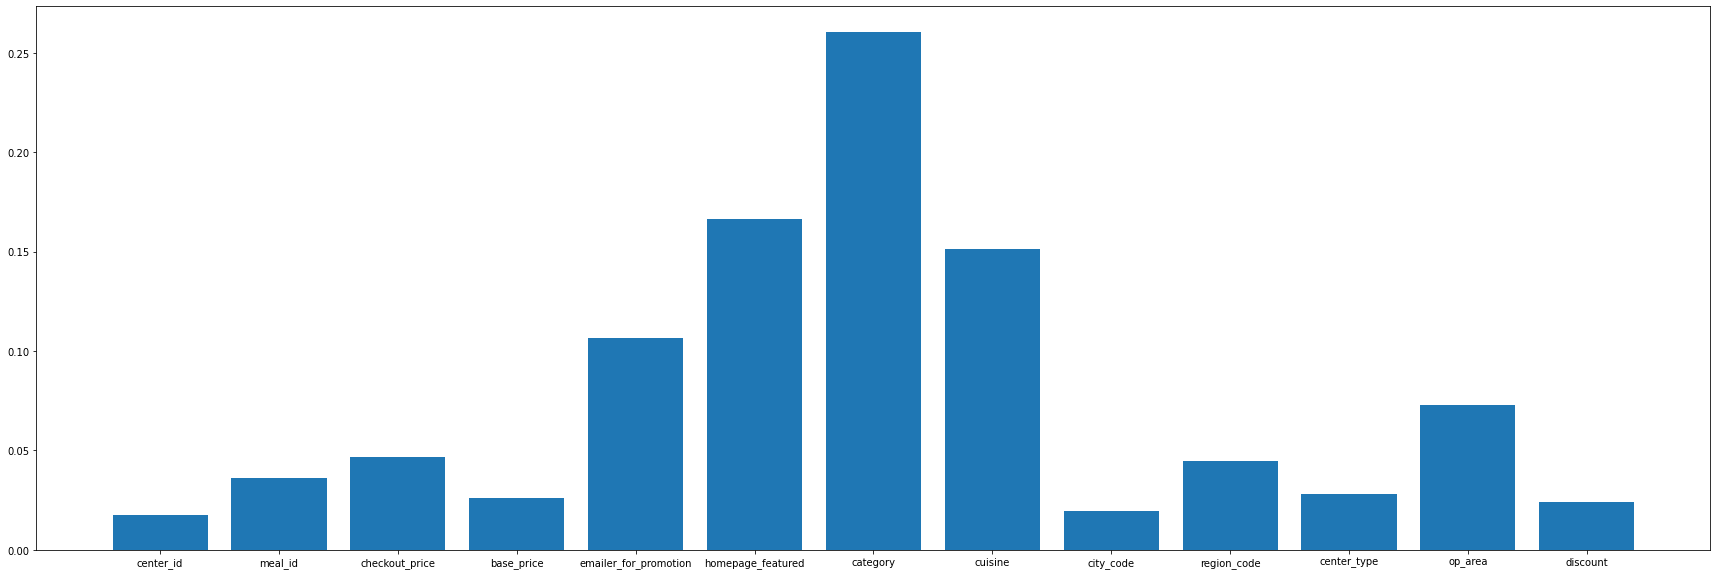

In [ ]:
plt.figure(figsize=(30,10))
plt.bar(*zip(*feat_imps.items()))

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
def best_ntree_score(estimator, X, y):
    """
    This scorer uses the best_ntree_limit to return
    the best AUC ROC score
    """
    try:
        y_predict = estimator.predict(X,ntree_limit=estimator.best_ntree_limit)
    except AttributeError:
        y_predict = estimator.predict(X)
    return roc_auc_score(y, y_predict[:, 1])

In [ ]:
yhat = model.predict(X_test)

In [ ]:
yhat = pd.DataFrame(yhat)
yhat.shape

(91310, 1)

In [ ]:
X_test.reset_index(inplace=True)
X_test.rename(columns={"index":"row_id"},inplace=True)
X_test


,row_id,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,category,cuisine,city_code,region_code,center_type,op_area,discount
0,365238,58,2139,432.62,432.62,0,0,0,1,695,77,2,3.8,0.000000
1,365239,58,2139,456.93,454.93,0,0,0,1,695,77,2,3.8,-0.004396
2,365240,58,2139,432.62,434.62,0,0,0,1,695,77,2,3.8,0.004602
3,365241,58,2139,455.93,454.93,0,0,0,1,695,77,2,3.8,-0.002198
4,365242,58,2139,454.93,454.93,0,0,0,1,695,77,2,3.8,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91305,456543,61,2104,583.03,630.53,0,1,4,0,473,77,0,4.5,0.075333
91306,456544,61,2104,581.03,582.03,0,0,4,0,473,77,0,4.5,0.001718
91307,456545,61,2104,583.03,581.03,0,0,4,0,473,77,0,4.5,-0.003442
91308,456546,61,2104,582.03,581.03,0,0,4,0,473,77,0,4.5,-0.001721


In [ ]:
X_test.shape

(91310, 14)

In [ ]:
yhat.shape

(91310, 1)

In [ ]:

prediction = pd.concat([X_test,yhat], axis=1, ignore_index=False)
prediction.rename(columns={'0':'pred'},inplace=True)


In [ ]:
prediction.rename(columns={'Unnamed: 0' : 'prediction'},inplace =True)

In [ ]:
prediction[prediction.columns[-1]]

0         24.914743
1         19.569118
2         24.790693
3         20.883289
4         20.712687
            ...    
91305    146.115921
91306     70.807304
91307     70.297394
91308     70.807304
91309     70.807304
Name: 0, Length: 91310, dtype: float32

In [ ]:
intpred = pd.DataFrame(prediction[prediction.columns[-1]].round())
intpred

,0
0,25.0
1,20.0
2,25.0
3,21.0
4,21.0
...,...
91305,146.0
91306,71.0
91307,70.0
91308,71.0


In [ ]:
prediction['intpred'] = intpred
prediction

,row_id,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,category,cuisine,city_code,region_code,center_type,op_area,discount,0,intpred
0,365238,58,2139,432.62,432.62,0,0,0,1,695,77,2,3.8,0.000000,24.914743,25.0
1,365239,58,2139,456.93,454.93,0,0,0,1,695,77,2,3.8,-0.004396,19.569118,20.0
2,365240,58,2139,432.62,434.62,0,0,0,1,695,77,2,3.8,0.004602,24.790693,25.0
3,365241,58,2139,455.93,454.93,0,0,0,1,695,77,2,3.8,-0.002198,20.883289,21.0
4,365242,58,2139,454.93,454.93,0,0,0,1,695,77,2,3.8,0.000000,20.712687,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91305,456543,61,2104,583.03,630.53,0,1,4,0,473,77,0,4.5,0.075333,146.115921,146.0
91306,456544,61,2104,581.03,582.03,0,0,4,0,473,77,0,4.5,0.001718,70.807304,71.0
91307,456545,61,2104,583.03,581.03,0,0,4,0,473,77,0,4.5,-0.003442,70.297394,70.0
91308,456546,61,2104,582.03,581.03,0,0,4,0,473,77,0,4.5,-0.001721,70.807304,71.0
